### packages

In [31]:
import numpy as np

import pandas as pd

import pulp

import networkx as nx

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from scipy.optimize import minimize

import math

import warnings

warnings.filterwarnings('ignore')

### parameters

\begin{equation}
u_{o,d,i} = \overbrace{\alpha_{0,o}}^{\textrm{constant term}} - \overbrace{\alpha_{1,o} \cdot f_{o,d,i}}^{\textrm{order fare}} - \overbrace{ \alpha_{2,o} \cdot \tau_{o,d} }^{\textrm{pick-up time}}, \forall o \in O,
\label{eq:order utility}
\end{equation}

\begin{equation}
v_{o,d,i} = \overbrace{\beta_{0,d}}^{\textrm{constant term}} + \overbrace{\beta_{1,d} \cdot w_{o,d,i}}^{\textrm{wage}} - \overbrace{ \beta_{2,d} \cdot \tau_{o,d} }^{\textrm{pick-up time}}, \forall d \in D
\label{eq:driver utility}
\end{equation}


In [32]:
################################################################################################

order_num=10

driver_num=10

################################################################################################

theta_0=2.505

theta_1=0.355

theta_2=1.055

lambda_=0.755

################################################################################################

theta_0_space=[1.0,4.0]

theta_1_space=[0.2,0.5]

theta_2_space=[0.7,1.4]

lambda_space=[0.6,0.9]

################################################################################################

alpha0=0

alpha1=3.2

alpha2=0.6

################################################################################################

beta0=0.0

beta1=2.0

beta2=0.5


################################################################################################
################################################################################################
################################################################################################
################################################################################################

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

################################################################################################
################################################################################################

iteration_df=pd.read_csv('iteration_df.csv')

iteration_df=iteration_df.drop(columns=['Unnamed: 0'])

iteration_df


,theta0,theta1,theta2,lambda,reward
0,1.000,0.200,0.700,0.600,0.328
1,1.000,0.200,0.700,0.633,0.329
2,1.000,0.200,0.700,0.667,0.329
3,1.000,0.200,0.700,0.700,0.299
4,1.000,0.200,0.700,0.733,0.299
...,...,...,...,...,...
99995,3.333,0.467,0.856,0.767,9.054
99996,2.000,0.400,1.089,0.733,10.102
99997,2.667,0.367,1.011,0.767,10.085
99998,2.000,0.367,1.089,0.767,10.026


### generate data

\begin{align}
\begin{split}
&f_{o,d,2}=\theta_{0}+ \theta_{1}\cdot \textrm{ETD}_{o} + \theta_{2}\cdot \textrm{ETT}_{o}
\label{eq: linear fare}
\end{split}
\end{align}

\begin{align}
\begin{split}
&w_{o,d,2}=\lambda f_{o,d,2}
\label{eq: linear wage}
\end{split}
\end{align}

In [33]:
ETD=np.random.uniform(3,10,order_num)

ETT=np.random.uniform(3,10,order_num)

################################################################################################

Fare2=theta_0*np.ones(order_num)+theta_1*ETD+theta_2*ETT

Fare2=np.tile(np.array([Fare2]).transpose(), (1,driver_num))

################################################################################################

Wage2=lambda_*Fare2

################################################################################################

Tau=np.random.uniform(3,10,[order_num,driver_num])

################################################################################################

U2=alpha0*np.ones([order_num,driver_num])-alpha1*Fare2-alpha2*Tau

################################################################################################

V2=beta0*np.ones([order_num,driver_num])+beta1*Wage2-beta2*Tau

################################################################################################

u_decline=np.quantile(U2, 0.25)

v_decline=np.quantile(V2, 0.25)

print('Deline utility of passenger is ',u_decline)

print('Deline utility of driver is ',v_decline)


Deline utility of passenger is  -42.195758829263355
Deline utility of driver is  11.010917310336037


### Ride-matching of platform 2

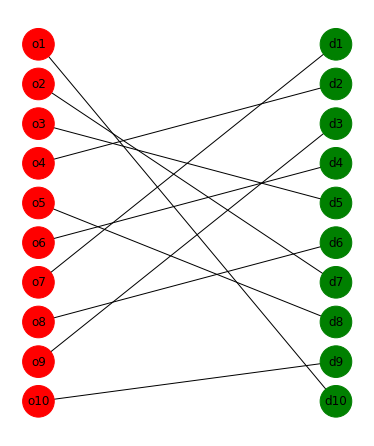

In [34]:
def Bipartite_matching(Weights):
    
    # model

    model = pulp.LpProblem("Ride_Matching_Problems", pulp.LpMaximize)

    # variables

    X = pulp.LpVariable.dicts("X",((O,D) for O in range(Weights.shape[0]) for D in range(Weights.shape[1])),lowBound=0,upBound=1,cat='Integer')

    # objective

    model += (pulp.lpSum([Weights[O,D] * X[(O, D)] for O in range(Weights.shape[0]) for D in range(Weights.shape[1])]))

    # constraints

    for O in range(Weights.shape[0]):

        model += pulp.lpSum([X[(O, D)] for D in range(Weights.shape[1])]) <= 1

    for D in range(Weights.shape[1]):

        model += pulp.lpSum([X[(O, D)] for O in range(Weights.shape[0])]) <= 1
            
    # solvable

    model.solve()
    
    x = np.zeros([Weights.shape[0],Weights.shape[1]])
    
    for var in X:

        var_value = X[var].varValue

        if var_value !=0:

            x [var[0]][var[1]]=1
            
    return x

################################################################################################
################################################################################################

Weights2=1/Tau

X2=Bipartite_matching(Weights2)

################################################################################################
################################################################################################

G2 = nx.Graph()

order_nodes=['o'+str(o+1) for o in range(order_num)]

driver_nodes=['d'+str(d+1) for d in range(order_num)]

for node in order_nodes:
    
    G2.add_node(node, level=0)
    
for node in driver_nodes:
    
    G2.add_node(node, level=1)
    
################################################################################################
################################################################################################

for o in range(order_num):

    for d in range(driver_num):
        
        if X2[o][d]==1:

            G2.add_edge('o'+str(o+1),'d'+str(d+1))

################################################################################################
################################################################################################

color_map = ['red' if 'o' in node else 'green' for node in G2.nodes()]  

pos = nx.multipartite_layout(G2, subset_key="level")

plt.figure(figsize=(5,6)) 

nx.draw(G2,pos,with_labels = True,node_size=1000,node_color=color_map)

plt.show()
   
        

### Observable static competition

Fare and wage optimization, determines the optimal fare and wage for an arbitrary order-driver pair $(o,d)$, which maximizes the expected profit of such pair,

\begin{align}
\begin{split}
\max_{f_{o,d,1},w_{o,d,1}} \mathcal{P}(f_{o,d,1},w_{o,d,1}),\forall o \in O, \forall d \in D
\label{eq: pricing and waging objective}
\end{split}\\
\begin{split}
\text{subject to }&f_{o,d,1} \geq 0, \forall o \in O, \forall d \in D
\label{eq: pricing fare range}
\end{split}\\
\begin{split}
&w_{o,d,1} \geq 0, \forall o \in O, \forall d \in D.
\label{eq: pricing wage range}
\end{split}
\end{align}

\begin{equation}
\begin{aligned}
\mathcal{P}(f_{o,d,1},w_{o,d,1}|f_{o,d,2},w_{o,d,2},x_{o,d,2})=&   \frac{\textrm{exp}(u_{o,d,1})}{\textrm{exp}(u_{o}^{\textrm{c}})+\sum_{d \in D} \textrm{exp}(u_{o,d,2})\cdot x_{o,d,2}+\textrm{exp}(u_{o,d,1})}\\
& \cdot \frac{\textrm{exp}(v_{o,d,1})}{\textrm{exp}(v_{d}^{\textrm{c}})+\sum_{o \in O} \textrm{exp}(v_{o,d,2})\cdot x_{o,d,2}+ \textrm{exp}(v_{o,d,1})}  \cdot (f_{o,d,1}-w_{o,d,1}).
\label{eq: OS FW objective}
\end{aligned}
\end{equation}

Matching optimization, can be formulated as a maximum-weighted bipartite matching problem. A bipartite graph is first constructed to represent all the potential matches between passengers and drivers. A weighted edge connects each pair of the passenger and driver nodes, and the weight is the optimal expected profit $\mathcal{P}(f^{*}_{o,d,1},w^{*}_{o,d,1})$ of order-driver pair $(o,d)$, $\forall o \in O$, $\forall d \in D$, derived from Fare and wage optimization,

\begin{align}
\begin{split}
&\max_{x_{o,d,1}} \mathbb{P} = \sum_{o\in O}\sum_{d\in D}  \mathcal{P}(f^{*}_{o,d,1},w^{*}_{o,d,1})  \cdot x_{o,d,1}
\label{eq: matching objective}
\end{split}\\
\begin{split}
\text{subject to}&\sum_{d \in D} x_{o,d,1} \leq  1, \forall o \in O
\label{eq: matching constrain 1}
\end{split}\\
\begin{split}
&\sum_{o \in O} x_{o,d,1} \leq 1, \forall d \in D
\label{eq: matching constrain 2}
\end{split}\\
\begin{split}
&x_{o,d,1} \in \{0,1\}, \forall o \in O, \forall d \in D.
\label{eq: matching matching range}
\end{split}
\end{align}

In [35]:
class NOS_optimization(object):
    
    ################################################################################################
    
    def __init__(self,u_decline,v_decline,Tau,ETD,ETT):
        
        ################################################################################################
       
        self.u_decline=u_decline
        
        self.v_decline=v_decline
        
        ################################################################################################
        
        self.Tau=Tau # pickup time of platform 2
        
        self.ETD=ETD # Estimated travel distance
        
        self.ETT=ETT # Estimated travel time
        
    ################################################################################################
    
    def sample_action(self):
        
        ################################################################################################
        
        order_num,driver_num=self.Tau.shape[0],self.Tau.shape[1]
        
        ################################################################################################
        
        guess_theta_0=np.random.uniform(theta_0_space[0],theta_0_space[1],1)
        
        guess_theta_1=np.random.uniform(theta_1_space[0],theta_1_space[1],1)
        
        guess_theta_2=np.random.uniform(theta_2_space[0],theta_2_space[1],1)
        
        guess_lambda=np.random.uniform(lambda_space[0],lambda_space[1],1)
        
        return guess_theta_0,guess_theta_1,guess_theta_2,guess_lambda
        
    ################################################################################################

    def profit(self,X,o,d,U2,V2,X2):
        
        ################################################################################################
        
        u1=alpha0-alpha1*X[0]-alpha2*self.Tau[o,d]
        
        v1=beta0+beta1*X[1]-beta2*self.Tau[o,d]
        
        ################################################################################################
        
        u2=U2[o,d]
        
        v2=V2[o,d]
        
        ################################################################################################
        
        u0=self.u_decline
        
        v0=self.v_decline
        
        ################################################################################################
        
        p=np.exp(u1)/(np.exp(u0)+np.exp(u2)+np.exp(u1))
    
        q=np.exp(v1)/(np.exp(v0)+np.exp(v2)+np.exp(v1))
        
        ################################################################################################
        
        return -1*p*q*(X[0]-X[1])
    
    ################################################################################################
    
    def weights(self,Fare1,Wage1,U2,V2,X2):
        
        ################################################################################################
        
        Weights=np.zeros([order_num,driver_num])
        
        ################################################################################################
        
        for o in range(order_num):

            for d in range(driver_num):
                
                X=[Fare1[o,d],Wage1[o,d]]
                
                Weights[o,d]=-1*self.profit(X,o,d,U2,V2,X2)
                
        return Weights
                
    ################################################################################################
    
    def solve(self,guess_theta_0,guess_theta_1,guess_theta_2,guess_lambda):
        
        ################################################################################################
        
        order_num,driver_num=self.Tau.shape[0],self.Tau.shape[1]
        
        ################################################################################################
        
        Fare1,Wage1,X1=np.zeros([order_num,driver_num]),np.zeros([order_num,driver_num]),np.zeros([order_num,driver_num])
        
        U1,V1=np.zeros([order_num,driver_num]),np.zeros([order_num,driver_num])
        
        ################################################################################################
        
        Fare2=guess_theta_0*np.ones(order_num)+guess_theta_1*self.ETD+guess_theta_2*self.ETT

        Fare2=np.tile(np.array([Fare2]).transpose(), (1,driver_num))
        
        ################################################################################################
        
        Wage2=guess_lambda*Fare2
        
        ################################################################################################
        
        U2=alpha0*np.ones([order_num,driver_num])-alpha1*Fare2-alpha2*self.Tau

        ################################################################################################

        V2=beta0*np.ones([order_num,driver_num])+beta1*Wage2-beta2*self.Tau
        
        ################################################################################################
        
        Weights2=Fare2-Wage2

        X2=Bipartite_matching(Weights2)
        
        ################################################################################################
        
        for o in range(order_num):

            for d in range(driver_num):
                
                fw_opt = minimize(self.profit,[Fare2[o,d],Wage2[o,d]],args=(o,d,U2,V2,X2),bounds=((0, None), (0, None)))
        
                if fw_opt.success:

                    Fare1[o,d]=fw_opt.x[0]

                    Wage1[o,d]=fw_opt.x[1]
                    
                else:
                    
                    print('fail')
        ################################################################################################
        
        Weights=self.weights(Fare1,Wage1,U2,V2,X2)
        
        X1=Bipartite_matching(Weights)
        
        ################################################################################################
        
        for o in range(order_num):

            for d in range(driver_num):
                
                U1[o,d]=alpha0-alpha1*Fare1[o,d]-alpha2*self.Tau[o,d]
                
                V1[o,d]=beta0+beta1*Wage1[o,d]-beta2*self.Tau[o,d]

        return Fare1,Wage1,X1,U1,V1
    
    def simulate(self,Fare1,Wage1,X1,U1,V1,Fare2,Wage2,X2,U2,V2):
        
        ################################################################################################
        ################################################################################################

        order_num,driver_num=X2.shape[0],X2.shape[1]

        ################################################################################################
        ################################################################################################

        order_selection={}

        driver_selection={}

        ################################################################################################
        ################################################################################################

        for o  in range(order_num):

            ################################################################################################
            ################################################################################################

            choice_set={'decline':u_decline}

            ################################################################################################
            ################################################################################################

            matching1,matching2=np.nonzero(X1[o,:])[0],np.nonzero(X2[o,:])[0]

            if len(matching1)>0:

                d1=matching1[0]

                choice_set['1']=U1[o,d1]

            if len(matching2)>0:

                d2=matching2[0]

                choice_set['2']=U2[o,d2]

            ################################################################################################
            ################################################################################################

            choice_prob={}

            exp_sum=sum([np.exp(u) for u in choice_set.values()])

            for select,utility in choice_set.items():

                choice_prob[select]=np.exp(utility)/exp_sum

            ################################################################################################
            ################################################################################################

            selection=np.random.choice(list(choice_prob.keys()),p=list(choice_prob.values()))

            if selection=='1':

                selection=selection+'_'+str(matching1[0])

            elif selection=='2':

                selection=selection+'_'+str(matching2[0])

            else:

                selection=selection+'_null'

            order_selection[o]=selection

        ################################################################################################
        ################################################################################################

        for d  in range(driver_num):

            ################################################################################################
            ################################################################################################

            choice_set={'decline':v_decline}

            ################################################################################################
            ################################################################################################

            matching1,matching2=np.nonzero(X1[:,d])[0],np.nonzero(X2[:,d])[0]

            if len(matching1)>0:

                o1=matching1[0]

                choice_set['1']=V1[o1,d]

            if len(matching2)>0:

                o2=matching2[0]

                choice_set['2']=V2[o2,d]

            ################################################################################################
            ################################################################################################

            choice_prob={}

            exp_sum=sum([np.exp(u) for u in choice_set.values()])

            for select,utility in choice_set.items():

                choice_prob[select]=np.exp(utility)/exp_sum

            ################################################################################################
            ################################################################################################

            selection=np.random.choice(list(choice_prob.keys()),p=list(choice_prob.values()))

            if selection=='1':

                selection=selection+'_'+str(matching1[0])

            elif selection=='2':

                selection=selection+'_'+str(matching2[0])

            else:

                selection=selection+'_null'

            driver_selection[d]=selection

        ################################################################################################
        ################################################################################################

        profit={'1':0,'2':0}

        matchings={'1':[],'2':[]}

        ################################################################################################
        ################################################################################################

        for o,order_select in order_selection.items():

            order_platform,d=order_select.split('_')[0],order_select.split('_')[1]

            if order_platform!="decline":

                d=int(d)

                driver_select=driver_selection[d]

                driver_platform=driver_select.split('_')[0]

                if driver_platform==order_platform:

                    matchings[driver_platform].append((o,d))

                    if driver_platform=='1':

                        profit[driver_platform]+=Fare1[o,d]-Wage1[o,d]

                    elif driver_platform=='2':

                        profit[driver_platform]+=Fare2[o,d]-Wage2[o,d]

        ################################################################################################
        ################################################################################################

        return profit['1']
                
    
    


### user example and simulate the choice behaviour

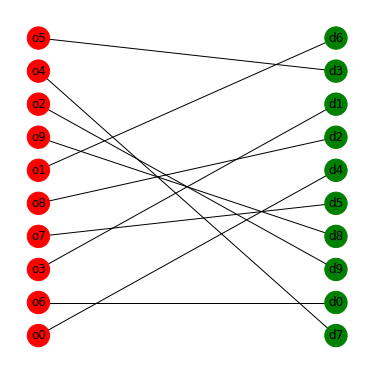

4.3750390921671505

In [36]:
################################################################################################

optimization=NOS_optimization(u_decline,v_decline,Tau,ETD,ETT)

guess_theta_0,guess_theta_1,guess_theta_2,guess_lambda=optimization.sample_action()

Fare1,Wage1,X1,U1,V1=optimization.solve(guess_theta_0,guess_theta_1,guess_theta_2,guess_lambda)

################################################################################################

G = nx.Graph()

order_nodes=['o'+str(o) for o in range(order_num)]

driver_nodes=['d'+str(d) for d in range(order_num)]

G.add_nodes_from(order_nodes, bipartite=0, label='passenger')

G.add_nodes_from(driver_nodes, bipartite=1, label='driver')

for o in range(order_num):

    for d in range(driver_num):
        
        if X1[o][d]==1:

            G.add_edge('o'+str(o),'d'+str(d))

################################################################################################

color_map = ['red' if 'o' in node else 'green' for node in G.nodes()]  

pos = nx.bipartite_layout(G, order_nodes)

plt.figure(figsize=(5,5)) 

nx.draw(G,pos,node_color=color_map,with_labels = True,node_size=500)

plt.show()

################################################################################################

optimization.simulate(Fare1,Wage1,X1,U1,V1,Fare2,Wage2,X2,U2,V2)

### UCB for continuous bandits

In [37]:
################################################################################################
################################################################################################

class Upper_confidence_Bound_continuous(object):
    
    def __init__(self,theta_0_space,theta_1_space,theta_2_space,lambda_space,discretization=5):
        
        ################################################################################################
        
        theta_0_candidates=np.linspace(theta_0_space[0],theta_0_space[1],discretization)

        theta_1_candidates=np.linspace(theta_1_space[0],theta_1_space[1],discretization)
        
        theta_2_candidates=np.linspace(theta_2_space[0],theta_2_space[1],discretization)
        
        lambda_candidates=np.linspace(lambda_space[0],lambda_space[1],discretization)
        
        ################################################################################################
        
        self.arms=list()
        
        for i in range(len(theta_0_candidates)):
            
            for j in range(len(theta_1_candidates)):
                
                for k in range(len(theta_2_candidates)):
                    
                    for l in range(len(lambda_candidates)):
                        
                        arm=(theta_0_candidates[i],theta_1_candidates[j],theta_2_candidates[k],lambda_candidates[l])
                        
                        self.arms.append(arm)
        
        ################################################################################################

        # number of arms
        
        self.k = len(self.arms)
        
        # step count
        
        self.n = 0
        
        # step count for each arm (numbers of selections of each machine)
        
        self.k_n = np.zeros(self.k)
        
        # average reward for each arm
        
        self.k_reward = np.zeros(self.k)
        
        # sum reward for each arm
        
        self.k_sum_reward = np.zeros(self.k)
        
        
    def select_action(self):
        
        # initialize an action
        
        action=0
        
        # set the maximal upper bound 
        
        max_upper_bound = 0
        
        # search for the action
        
        for i in range(self.k):
            
            if self.k_n[i] > 0:
                
                Delta = math.sqrt(3/2 * math.log(self.n + 1)/self.k_n[i])
                
                upper_bound=self.k_reward[i]+Delta
                
            else:
                
                upper_bound=1e400
                
            if upper_bound > max_upper_bound:
                
                max_upper_bound = upper_bound
                
                # arm with the maximum upper bound
        
                action=i
            
        return action
    
    def update_Bounds(self,action, reward):
        
        self.k_n[action] += 1
        
        # update counts
        
        self.n += 1
        
        self.k_n[action] += 1
        
        self.k_sum_reward[action] += reward
        
        # update mean rewards for action 
        
        self.k_reward[action] = self.k_sum_reward[action] / self.k_n[action]
     


### optimization

In [38]:
iters=1

################################################################################################
################################################################################################
################################################################################################
################################################################################################

agent=Upper_confidence_Bound_continuous(theta_0_space,theta_1_space,theta_2_space,lambda_space)

################################################################################################

env=NOS_optimization(u_decline,v_decline,Tau,ETD,ETT)

################################################################################################

action_selections=list()


################################################################################################


for i in range(iters):
    
    ################################################################################################
    
    action=agent.select_action()
    
    actual_action=agent.arms[action]
    
    guess_theta_0,guess_theta_1,guess_theta_2,guess_lambda=actual_action[0],actual_action[1],actual_action[2],actual_action[3]
    
    ################################################################################################

    Fare1,Wage1,X1,U1,V1=env.solve(guess_theta_0,guess_theta_1,guess_theta_2,guess_lambda)
    
    reward=env.simulate(Fare1,Wage1,X1,U1,V1,Fare2,Wage2,X2,U2,V2)
    
    ################################################################################################
    
    agent.update_Bounds(action, reward)
    
    action_selections.append(action)
                
    if i%1==0:
        
        print("*"*100)
        
        print('Episode is ',i,' reward is ',reward)
        
        print('Selected arm is ',guess_theta_0,guess_theta_1,guess_theta_2,guess_lambda)
                          
            
# iteration_df.to_csv('iteration_df.csv')




****************************************************************************************************
Episode is  0  reward is  1.5454754629137684
Selected arm is  1.0 0.2 0.7 0.6


### Visualization

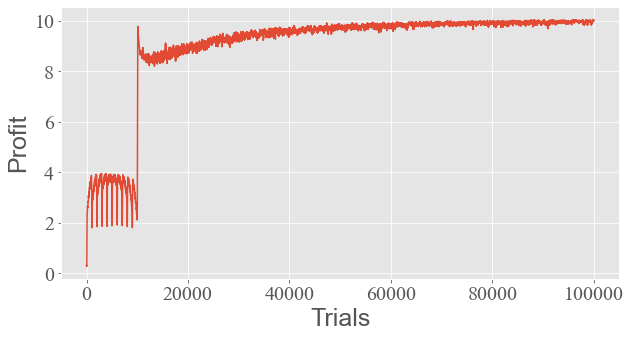

In [52]:
plt.style.use('ggplot')

def get_running_reward(reward_array: np.ndarray, window=100):
    
    """calculate the running reward, i.e. average of last `window` elements from rewards"""
    
    running_reward = np.zeros_like(reward_array)
    
    for i in range(window - 1):
        
        running_reward[i] = np.mean(reward_array[:i + 1])
        
    for i in range(window - 1, len(reward_array)):
        
        running_reward[i] = np.mean(reward_array[i - window + 1:i + 1])
        
    return running_reward

########################################################################################################
########################################################################################################

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

fig, axs = plt.subplots(figsize = (10,5))

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

# axs.grid()

########################################################################################################
########################################################################################################

# axs.plot(range(iteration_df.shape[0]), iteration_df.reward)

axs.plot(range(iteration_df.shape[0]), get_running_reward(iteration_df.reward))
    
########################################################################################################
########################################################################################################

axs.set_xlabel('Trials',font_label)

axs.set_ylabel('Profit',font_label)

plt.show()

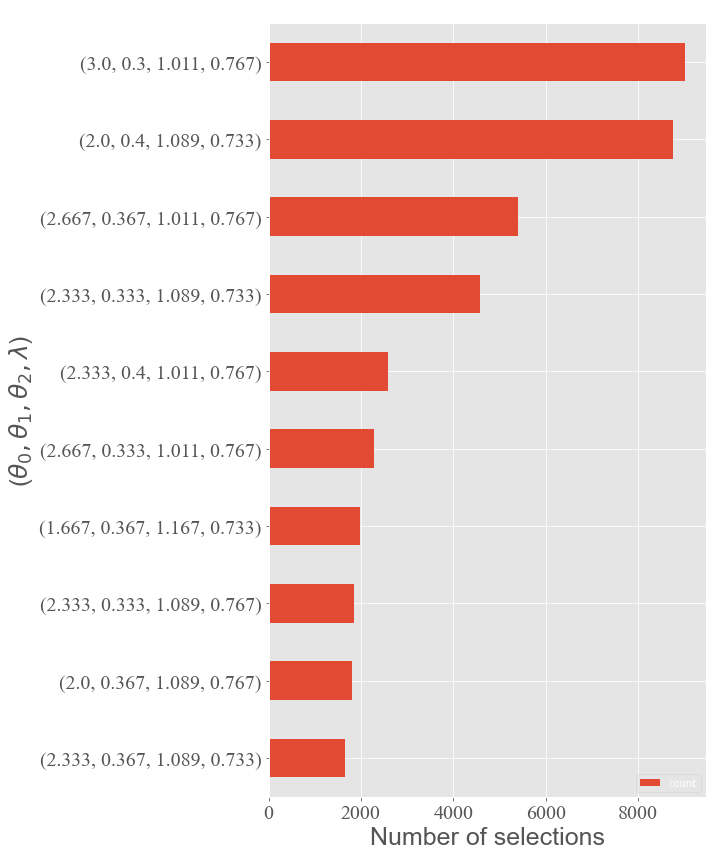

In [51]:
#########################################################################################
#########################################################################################

count_df=iteration_df.groupby(['theta0','theta1','theta2','lambda']).count()

count_df=count_df[['reward']]

count_df=count_df.rename(columns={'reward':'count'})

count_df=count_df.sort_values(by=['count'],ascending=False)

count_df=count_df.iloc[:10]

count_df['arm']=count_df.index

count_df=count_df.iloc[::-1]

count_df

#########################################################################################
#########################################################################################

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

fig, axs = plt.subplots(figsize = (10,12))

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

axs.grid()



count_df.plot.barh(x='arm', y='count',ax=axs, subplots=True)

axs.set_ylabel('($\\theta_{0},\\theta_{1},\\theta_{2},\\lambda$)',font_label)

axs.set_xlabel('Number of selections',font_label)

# xmajorLocator  = MultipleLocator(1)

# axs.xaxis.set_major_locator(xmajorLocator)

plt.tight_layout()

plt.show()

### dynamic model

In [45]:
theta_0_candidates=[round(x,3) for x in np.linspace(theta_0_space[0],theta_0_space[1],10)]

theta_1_candidates=[round(x,3) for x in np.linspace(theta_1_space[0],theta_1_space[1],10)]

theta_2_candidates=[round(x,3) for x in np.linspace(theta_2_space[0],theta_2_space[1],10)]

lambda_candidates=[round(x,3) for x in np.linspace(lambda_space[0],lambda_space[1],10)]



In [48]:
lambda_candidates

[0.6, 0.633, 0.667, 0.7, 0.733, 0.767, 0.8, 0.833, 0.867, 0.9]

In [2]:
11.2337*1573

17670.6101